In [2]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-12-13 18:34:17.338425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('./Metro_Interstate_Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
RAW_CSV = './Metro_Interstate_Traffic_Volume.csv'
CLEAN_CSV = './I94_Clean.csv'
MAX_RAIN_SNOW =50
MAX_TRAFFIC = 8000
MIN_TRAFFIC = 0


In [5]:
def _to_bool_or_none(x):
    if pd.isna(x):
        return None
    s = str(x).strip().lower()
    if s in ("none", "nan", "", "null"):
        return None
    return x  # 保留原节日名，后面另给 holiday_bool

def clean_i94(raw_csv=RAW_CSV, out_csv=CLEAN_CSV):
    # 1) 读取与基础规范
    df = pd.read_csv(raw_csv)
    # 统一列名：小写 + 下划线
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    # 解析时间并排序
    df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")
    df = df.dropna(subset=["date_time"]).sort_values("date_time").reset_index(drop=True)

    # 2) 去重（同一时间戳保留第一条）
    df = df.drop_duplicates(subset=["date_time"], keep="first")

    # 3) 统一时间频率（按小时对齐），补齐缺失小时
    df = df.set_index("date_time")
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="H")
    df = df.reindex(full_idx)
    df.index.name = "date_time"

    # 4) 数值字段清洗与修正
    # 温度：Kelvin -> 摄氏
    if "temp" in df.columns:
        df["temp_c"] = df["temp"] - 273.15

    # 雨/雪：负值归零，极端值裁剪
    for col in ["rain_1h", "snow_1h"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
            df[col] = df[col].clip(lower=0)               # 负值归零
            df[col] = df[col].clip(upper=MAX_RAIN_SNOW)   # 裁剪上限

    # 云量：限定 0~100
    if "clouds_all" in df.columns:
        df["clouds_all"] = pd.to_numeric(df["clouds_all"], errors="coerce").clip(0, 100)

    # 风速/能见度（若存在）：负值归零
    for col in ["wind_speed", "visibility"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").clip(lower=0)

    # 交通量：不合理值设为 NaN，待后续删除
    if "traffic_volume" in df.columns:
        df["traffic_volume"] = pd.to_numeric(df["traffic_volume"], errors="coerce")
        mask_bad = (df["traffic_volume"] < MIN_TRAFFIC) | (df["traffic_volume"] > MAX_TRAFFIC)
        df.loc[mask_bad, "traffic_volume"] = np.nan

    # 5) 类别字段规范
    for col in ["weather_main", "weather_description"]:
        if col in df.columns:
            df[col] = df[col].astype("string").str.strip().str.lower()

    if "holiday" in df.columns:
        # 原 holiday 字段清洗（保留节名或 None）
        df["holiday_raw"] = df["holiday"].map(_to_bool_or_none)
    else:
        df["holiday_raw"] = None

    # 6) 生成“是否联邦节假日”布尔列（基于日期）
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min().date(), end=df.index.max().date())
    df["is_us_federal_holiday"] = df.index.normalize().isin(holidays)

    # 7) 缺失值处理策略
    # 天气数值类：短缺口前向填充（最多 3 小时），再后向补；类别用最近值填
    num_weather_cols = [c for c in ["temp", "temp_c", "rain_1h", "snow_1h", "clouds_all", "wind_speed", "visibility"] if c in df.columns]
    if num_weather_cols:
        df[num_weather_cols] = df[num_weather_cols].fillna(method="ffill", limit=3).fillna(method="bfill", limit=3)

    cat_cols = [c for c in ["weather_main", "weather_description"] if c in df.columns]
    for c in cat_cols:
        df[c] = df[c].fillna(method="ffill").fillna(method="bfill")

    # 目标列：缺失的小时直接删除（不可随意填）
    if "traffic_volume" in df.columns:
        df = df.dropna(subset=["traffic_volume"])

    # 8) 可选：删除仍存在大量缺失的行
    df = df.dropna(how="any", subset=num_weather_cols)  # 保守做法：关键天气仍缺就删

    # 9) 导出
    df.to_csv(out_csv, index=True)
    print(f"[OK] Cleaned data saved to: {out_csv}")
    return df

if __name__ == "__main__":
    clean_i94()

/export/scratch_large/ding/tmp/ipykernel_2188057/3420918872.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(df.index.min(), df.index.max(), freq="H")
/export/scratch_large/ding/tmp/ipykernel_2188057/3420918872.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[num_weather_cols] = df[num_weather_cols].fillna(method="ffill", limit=3).fillna(method="bfill", limit=3)
/export/scratch_large/ding/tmp/ipykernel_2188057/3420918872.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[c] = df[c].fillna(method="ffill").fillna(method="bfill")


[OK] Cleaned data saved to: ./I94_Clean.csv


In [6]:
df_clean = pd.read_csv('./I94_Clean.csv', index_col=0, parse_dates=True)
df_clean.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,temp_c,holiday_raw,is_us_federal_holiday
date_time,,,,,,,,,,,
2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40.0,clouds,scattered clouds,5545.0,15.13,NaN,False
2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75.0,clouds,broken clouds,4516.0,16.21,NaN,False
2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90.0,clouds,overcast clouds,4767.0,16.43,NaN,False
2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90.0,clouds,overcast clouds,5026.0,16.98,NaN,False
2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75.0,clouds,broken clouds,4918.0,17.99,NaN,False


In [7]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40575 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   holiday                53 non-null     object 
 1   temp                   40575 non-null  float64
 2   rain_1h                40575 non-null  float64
 3   snow_1h                40575 non-null  float64
 4   clouds_all             40575 non-null  float64
 5   weather_main           40575 non-null  object 
 6   weather_description    40575 non-null  object 
 7   traffic_volume         40575 non-null  float64
 8   temp_c                 40575 non-null  float64
 9   holiday_raw            53 non-null     object 
 10  is_us_federal_holiday  40575 non-null  bool   
dtypes: bool(1), float64(6), object(4)
memory usage: 3.4+ MB


In [9]:
df_clean.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,temp_c
count,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000
mean,281.316360,0.077400,0.000117,44.195835,3290.650474,8.166360
std,13.817015,0.799371,0.005676,38.684567,1984.772909,13.817015
min,0.000000,0.000000,0.000000,0.000000,0.000000,-273.150000
25%,271.840000,0.000000,0.000000,1.000000,1248.500000,-1.310000
50%,282.860000,0.000000,0.000000,40.000000,3427.000000,9.710000
75%,292.280000,0.000000,0.000000,90.000000,4952.000000,19.130000
max,310.070000,50.000000,0.510000,100.000000,7280.000000,36.920000


In [10]:
df_clean['hour'] = df_clean.index.hour
df_clean['dayofweek'] = df_clean.index.dayofweek
df_clean['month'] = df_clean.index.month
df_clean['year'] = df_clean.index.year
df_clean['is_weekend'] = (df_clean['dayofweek'] >= 5).astype(int)

# 周期编码
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

/export/scratch_large/ding/tmp/ipykernel_1436475/4043838006.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


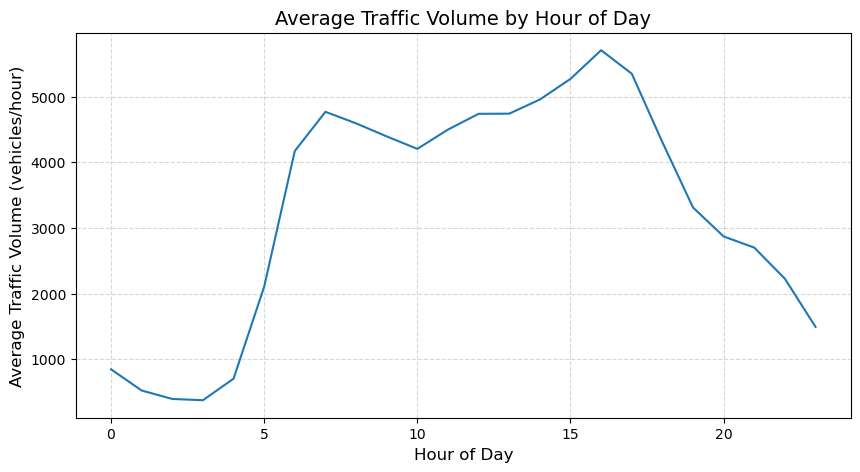

In [11]:
#一天中流量变化规律
plt.figure(figsize=(10,5))
sns.lineplot(
    x=df_clean['hour'],
    y=df_clean['traffic_volume'],
    estimator='mean',
    ci=None
)

plt.title('Average Traffic Volume by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Traffic Volume (vehicles/hour)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


/export/scratch_large/ding/tmp/ipykernel_2188057/1772178412.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


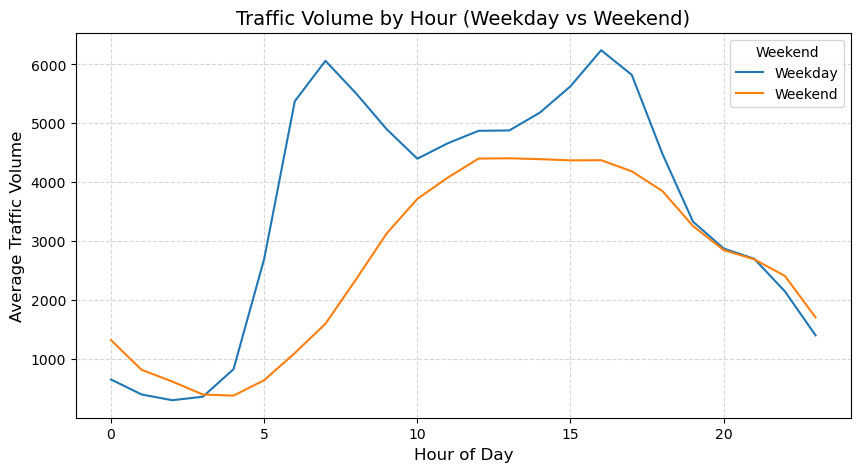

In [11]:
#工作日vs周末
plt.figure(figsize=(10,5))
sns.lineplot(
    x='hour',
    y='traffic_volume',
    hue='is_weekend',
    data=df_clean,
    estimator='mean',
    ci=None
)
plt.title('Traffic Volume by Hour (Weekday vs Weekend)', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Traffic Volume', fontsize=12)
plt.legend(title='Weekend', labels=['Weekday', 'Weekend'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

/export/scratch_large/ding/tmp/ipykernel_2188057/875950026.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='traffic_volume', data=monthly_avg, palette='viridis')


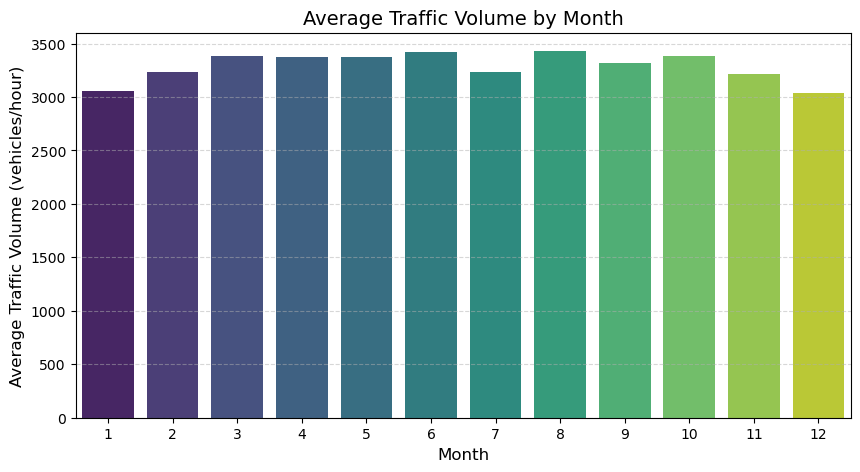

In [12]:
#不同月份的平均流量
if 'month' not in df_clean.columns:
    df_clean['month'] = df_clean.index.month

# 计算每月平均流量
monthly_avg = df_clean.groupby('month')['traffic_volume'].mean().reset_index()

# 绘图
plt.figure(figsize=(10,5))
sns.barplot(x='month', y='traffic_volume', data=monthly_avg, palette='viridis')

plt.title('Average Traffic Volume by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Traffic Volume (vehicles/hour)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


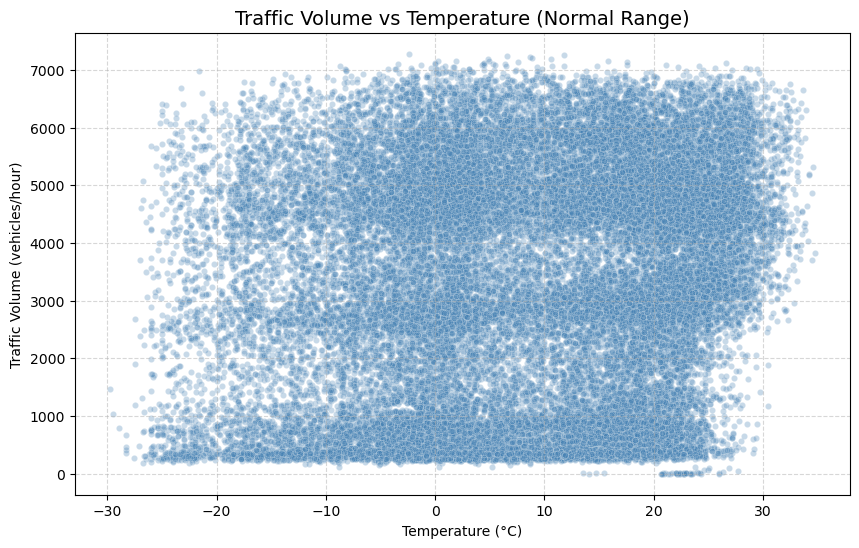

In [13]:
df_normal = df_clean[(df_clean['temp_c'] >= -30) & (df_clean['temp_c'] <= 35)]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='temp_c',
    y='traffic_volume',
    data=df_normal,
    alpha=0.3,
    s=20,
    color='steelblue'
)
plt.title('Traffic Volume vs Temperature (Normal Range)', fontsize=14)
plt.xlabel('Temperature (°C)')
plt.ylabel('Traffic Volume (vehicles/hour)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


/export/scratch_large/ding/tmp/ipykernel_2188057/1795131410.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


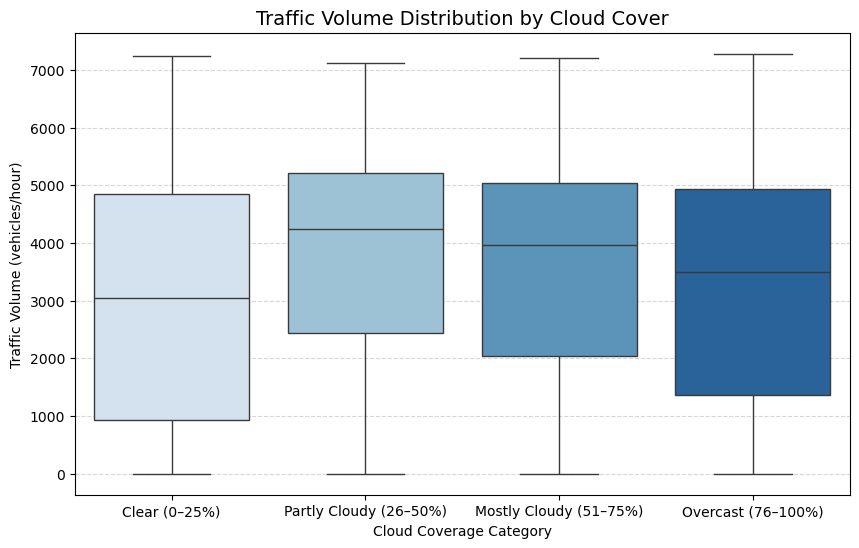

In [14]:
#云层分
df_clean['cloud_category'] = pd.cut(
    df_clean['clouds_all'],
    bins=[-1, 25, 50, 75, 100],
    labels=['Clear (0–25%)', 'Partly Cloudy (26–50%)',
            'Mostly Cloudy (51–75%)', 'Overcast (76–100%)']
)

plt.figure(figsize=(10,6))
sns.boxplot(
    x='cloud_category',
    y='traffic_volume',
    data=df_clean,
    palette='Blues'
)
plt.title('Traffic Volume Distribution by Cloud Cover', fontsize=14)
plt.xlabel('Cloud Coverage Category')
plt.ylabel('Traffic Volume (vehicles/hour)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [29]:
#线性回归
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# split_index = int(len(df_clean) * 0.8)
# train = df_clean.iloc[:split_index]
# test = df_clean.iloc[split_index:]

split_date_train = '2017-01-01'
split_date_val   = '2018-01-01'
train = df_clean[df_clean.index < split_date_train]
val   = df_clean[(df_clean.index >= split_date_train) & (df_clean.index < split_date_val)]
test  = df_clean[df_clean.index >= split_date_val]

# 特征列（排除目标变量）
feature_cols = ['hour_sin','hour_cos','dayofweek','is_weekend','temp_c','rain_1h','snow_1h','clouds_all']
X_train, y_train = train[feature_cols], train['traffic_volume']
X_test, y_test = test[feature_cols], test['traffic_volume']

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# 计算误差
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)


print(f"Linear Regression -> MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R2: {r2_lr:.3f}")


Linear Regression -> MAE: 841.10, RMSE: 1077.93, R2: 0.702


In [30]:
Accuracy_lr = round(r2_lr * 100,2)
print(f"Accuracy_lr: {Accuracy_lr}%")

Accuracy_lr: 70.19%


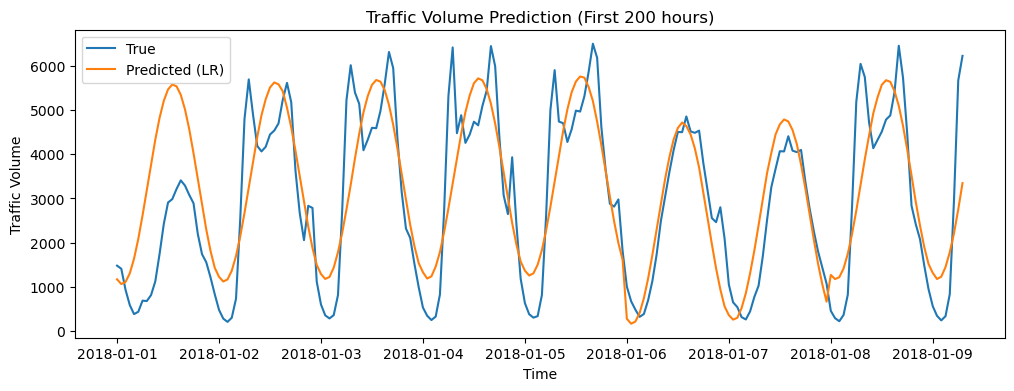

In [31]:
plt.figure(figsize=(12,4))
plt.plot(y_test.index[:200], y_test.values[:200], label='True')
plt.plot(y_test.index[:200], y_pred_lr[:200], label='Predicted (LR)')
plt.legend()
plt.title('Traffic Volume Prediction (First 200 hours)')
plt.xlabel('Time'); plt.ylabel('Traffic Volume')
plt.show()

In [32]:

from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest -> MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R2: {r2_rf:.3f}")


Random Forest -> MAE: 305.63, RMSE: 519.06, R2: 0.931


In [33]:
Accuracy_lr = round(r2_rf * 100,2)
print(f"Accuracy_rf: {Accuracy_lr}%")

Accuracy_rf: 93.09%


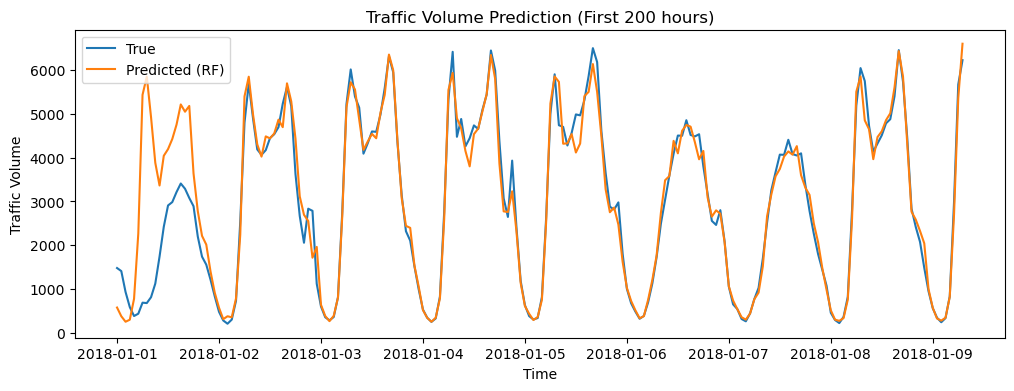

In [34]:
plt.figure(figsize=(12,4))
plt.plot(y_test.index[:200], y_test.values[:200], label='True')
plt.plot(y_test.index[:200], y_pred_rf[:200], label='Predicted (RF)')
plt.legend()
plt.title('Traffic Volume Prediction (First 200 hours)')
plt.xlabel('Time'); plt.ylabel('Traffic Volume')
plt.show()


In [35]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 假设你已经有 X_train, X_test, y_train, y_test

# 建立 LightGBM 回归模型
model_lgbm = LGBMRegressor(
    n_estimators=50,      # 树的数量，可以适当大一点
    learning_rate=0.05,   # 学习率
    max_depth=-1,         # 不限制树深度，由叶子数控制复杂度
    num_leaves=31,        # 叶子数，控制模型复杂度
    subsample=0.8,        # 行采样
    colsample_bytree=0.8, # 列采样
    random_state=42,
    n_jobs=-1
)

# 训练
model_lgbm.fit(X_train, y_train)

# 预测
y_pred_lgbm = model_lgbm.predict(X_test)

# 评估指标
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM -> MAE: {mae_lgbm:.2f}, RMSE: {rmse_lgbm:.2f}, R2: {r2_lgbm:.3f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 25329, number of used features: 8
[LightGBM] [Info] Start training from score 3252.511943
LightGBM -> MAE: 385.35, RMSE: 531.86, R2: 0.927


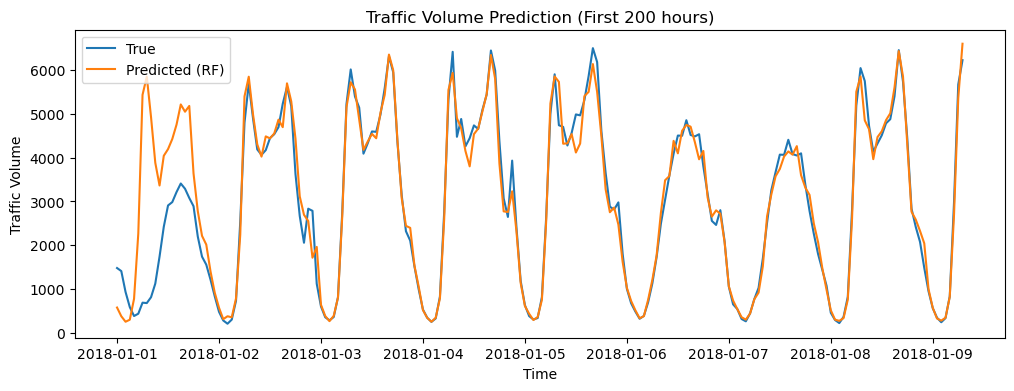

In [38]:
plt.figure(figsize=(12,4))
plt.plot(y_test.index[:200], y_test.values[:200], label='True')
plt.plot(y_test.index[:200], y_pred_rf[:200], label='Predicted (RF)')
plt.legend()
plt.title('Traffic Volume Prediction (First 200 hours)')
plt.xlabel('Time'); plt.ylabel('Traffic Volume')
plt.show()


In [36]:
df = df_clean.copy()

# 确保时间索引
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df['date_time'])
    df = df.set_index('date_time').sort_index()

# 选择特征
feature_cols = ['hour_sin','hour_cos','dayofweek','is_weekend',
                'temp_c','rain_1h','snow_1h','clouds_all']
target_col = 'traffic_volume'
df = df[feature_cols + [target_col]].dropna()

feature_cols_with_target = feature_cols + [target_col]
# 时间划分（防泄漏）
split_date_train = '2017-01-01'
split_date_val   = '2018-01-01'
train_df = df[df.index < split_date_train]
val_df   = df[(df.index >= split_date_train) & (df.index < split_date_val)]
test_df  = df[df.index >= split_date_val]

# 标准化：只用训练集拟合
X_scaler = StandardScaler().fit(train_df[feature_cols_with_target])
y_scaler = StandardScaler().fit(train_df[[target_col]])  # 方便反标准化

def scale_xy(frame):
    X = X_scaler.transform(frame[feature_cols_with_target])
    y = y_scaler.transform(frame[[target_col]])  # 2D
    return X, y

X_tr, y_tr = scale_xy(train_df)
X_va, y_va = scale_xy(val_df)
X_te, y_te = scale_xy(test_df)

# 窗口化序列（多变量输入，单变量输出）
def make_windows(X, y, window=24, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        Xs.append(X[i:i+window, :])              # [window, n_features]
        ys.append(y[i+window+horizon-1, 0])      # 标量
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

WINDOW = 24   # 用过去24小时
HORIZON = 1   # 预测下一小时
Xtr_seq, ytr_seq = make_windows(X_tr, y_tr, WINDOW, HORIZON)
Xva_seq, yva_seq = make_windows(X_va, y_va, WINDOW, HORIZON)
Xte_seq, yte_seq = make_windows(X_te, y_te, WINDOW, HORIZON)

print(Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape)  # (N, window, feat)



(25305, 24, 9) (8689, 24, 9) (6509, 24, 9)


In [37]:
# ===== 2) 定义与训练 LSTM =====
tf.random.set_seed(42)
model = Sequential([
    LSTM(64, input_shape=(WINDOW, Xtr_seq.shape[-1])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5)
]

history = model.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xva_seq, yva_seq),
    epochs=20, batch_size=256,
    callbacks=callbacks, verbose=1
)

# ===== 3) 评估：反标准化再算指标 =====
y_pred_te = model.predict(Xte_seq, verbose=0).reshape(-1, 1)
# 反标准化
y_pred_te_inv = y_scaler.inverse_transform(y_pred_te).ravel()
y_true_te_inv = y_scaler.inverse_transform(yte_seq.reshape(-1,1)).ravel()

MAE  = mean_absolute_error(y_true_te_inv, y_pred_te_inv)
MSE  = mean_squared_error(y_true_te_inv, y_pred_te_inv)
RMSE = np.sqrt(MSE)  # 改这里！
R2   = r2_score(y_true_te_inv, y_pred_te_inv)
ACC  = round(R2 * 100, 2)

print(f"LSTM -> MAE: {MAE:.2f}, RMSE: {RMSE:.2f}, R²: {R2:.3f}, Accuracy(%): {ACC}")

# ===== 4) 与传统模型结果并表（若已有lr/rf结果，可追加） =====
res_lstm = pd.DataFrame([['LSTM', MAE, RMSE, R2, ACC]],
                        columns=['Model','MAE','RMSE','R2','Accuracy(%)'])
print(res_lstm)

Epoch 1/20


/export/scratch_large/ding/.conda/envs/5523/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.4325 - val_loss: 0.2131 - learning_rate: 0.0010
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.2661 - val_loss: 0.1464 - learning_rate: 0.0010
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.2261 - val_loss: 0.1387 - learning_rate: 0.0010
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.2055 - val_loss: 0.1234 - learning_rate: 0.0010
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1897 - val_loss: 0.1113 - learning_rate: 0.0010
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.1793 - val_loss: 0.1126 - learning_rate: 0.0010
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1728 - val_loss: 0.1099 - learning_rate: 0.0010
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1682 - val_loss: 0.1068 - learning_rate: 0.0010
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.1629 - val_loss: 0.1049 - learning_rate: 0.0010
Epoch 10/20
99/99 ━━━━━━━━━━━━

In [28]:
# ===== 0) 必要导入 =====
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from itertools import product

# 固定随机种子，保证结果尽量可复现
np.random.seed(42)
tf.random.set_seed(42)

# 这里假设你已经有：
# Xtr_seq, ytr_seq, Xva_seq, yva_seq, Xte_seq, yte_seq
# 以及 y_scaler（用 StandardScaler 拟合过训练集 y）
# 如果前面是按你之前发给我的代码来的，这些变量应该已经准备好了。


# ===== 1) 定义：构建 LSTM 模型的函数 =====
def build_lstm_model(input_shape,
                     hidden_units=64,
                     dropout_rate=0.3,
                     l2_reg=1e-4,
                     learning_rate=1e-3):
    """
    构建带有正则化和归一化的 LSTM 模型：
    - L2 正则：kernel & recurrent
    - BatchNormalization：提升训练稳定性
    - Dropout：防止过拟合
    """
    model = Sequential([
        # LSTM 层，带 L2 正则
        LSTM(
            hidden_units,
            input_shape=input_shape,
            kernel_regularizer=l2(l2_reg),
            recurrent_regularizer=l2(l2_reg),
            bias_regularizer=l2(l2_reg)
        ),
        BatchNormalization(),          # 归一化，有助于稳定训练
        Dropout(dropout_rate),         # 可调的 dropout

        Dense(hidden_units // 2,
              activation='relu',
              kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),          # 再加一层 BN
        Dropout(dropout_rate / 2),     # 再加一点点 dropout

        Dense(1)                       # 输出一维连续值（标准化后的 y）
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')
    return model


# ===== 2) 定义超参数搜索空间 =====
# 可以按需要缩小/扩大
param_grid = {
    "hidden_units":  [32, 64],        # LSTM 单元数
    "dropout_rate":  [0.2, 0.4],      # Dropout 比例
    "learning_rate": [1e-3, 5e-4],    # 学习率
    "batch_size":    [128, 256]       # 批大小
}

input_shape = (Xtr_seq.shape[1], Xtr_seq.shape[2])  # (WINDOW, n_features)

# ===== 3) 提前定义回调（早停 + 动态调学习率） =====
def get_callbacks():
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-5
        )
    ]


# ===== 4) 简易“网格搜索”：遍历一批 LSTM 配置，选 val_loss 最小的 =====
best_val_loss = np.inf
best_config = None
best_model = None
history_dict = {}   # 如果想之后画 loss 曲线可以用

for hidden_units, dropout_rate, learning_rate, batch_size in product(
    param_grid["hidden_units"],
    param_grid["dropout_rate"],
    param_grid["learning_rate"],
    param_grid["batch_size"]
):
    config = {
        "hidden_units": hidden_units,
        "dropout_rate": dropout_rate,
        "learning_rate": learning_rate,
        "batch_size": batch_size
    }
    print("\n==== Try config:", config)

    # 构建模型
    model = build_lstm_model(
        input_shape=input_shape,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    # 训练
    history = model.fit(
        Xtr_seq, ytr_seq,
        validation_data=(Xva_seq, yva_seq),
        epochs=20,                # 给多一点 epochs，早停会自动“刹车”
        batch_size=batch_size,
        callbacks=get_callbacks(),
        verbose=0                 # 不想太吵可以设 0；调试时可以改成 1
    )

    # 当前配置的最好 val_loss
    val_loss_min = min(history.history['val_loss'])
    history_dict[str(config)] = history.history

    print(f"Config {config} -> best val_loss: {val_loss_min:.4f}")

    # 如果这个配置更好，就更新最佳模型
    if val_loss_min < best_val_loss:
        best_val_loss = val_loss_min
        best_config = config
        best_model = model

print("\n==== Best config:", best_config)
print(f"Best val_loss: {best_val_loss:.4f}")


# ===== 5) 用最优模型在测试集上评估（要反标准化） =====
# 预测（输出仍是标准化后的值）
y_pred_te = best_model.predict(Xte_seq, verbose=0).reshape(-1, 1)

# 反标准化回到原始单位（车辆/小时）
y_pred_te_inv = y_scaler.inverse_transform(y_pred_te).ravel()
y_true_te_inv = y_scaler.inverse_transform(yte_seq.reshape(-1, 1)).ravel()

# 计算指标
MAE  = mean_absolute_error(y_true_te_inv, y_pred_te_inv)
MSE  = mean_squared_error(y_true_te_inv, y_pred_te_inv)
RMSE = np.sqrt(MSE)
R2   = r2_score(y_true_te_inv, y_pred_te_inv)
ACC  = round(R2 * 100, 2)

print(f"\nLSTM (best config) -> MAE: {MAE:.2f}, RMSE: {RMSE:.2f}, R²: {R2:.3f}, Accuracy(%): {ACC}")

# 结果整理成表格，方便跟线性回归 / 随机森林等对比
res_lstm = pd.DataFrame(
    [['LSTM (tuned)', MAE, RMSE, R2, ACC,
      best_config['hidden_units'],
      best_config['dropout_rate'],
      best_config['learning_rate'],
      best_config['batch_size']]],
    columns=['Model','MAE','RMSE','R2','Accuracy(%)',
             'hidden_units','dropout','lr','batch_size']
)

print("\nFinal LSTM result table:")
print(res_lstm)



==== Try config: {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 128}
Config {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 128} -> best val_loss: 0.1560

==== Try config: {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 256}
Config {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 256} -> best val_loss: 0.1588

==== Try config: {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 128}
Config {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 128} -> best val_loss: 0.1580

==== Try config: {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 256}
Config {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 256} -> best val_loss: 0.1689

==== Try config: {'hidden_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128}
Config {'hidd

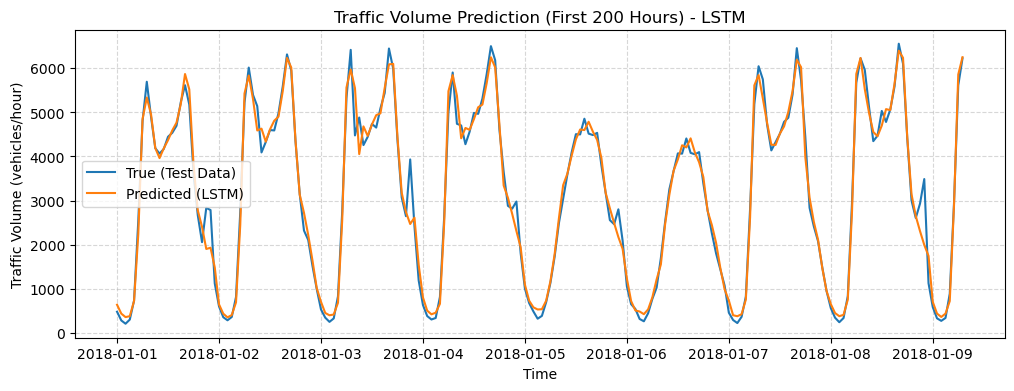

In [28]:
# 获取测试集对应的时间索引
test_index = test_df.index   # test_df 是你之前按时间切割得到的测试集

plt.figure(figsize=(12,4))
plt.plot(test_index[:200], y_true_te_inv[:200], label='True (Test Data)')
plt.plot(test_index[:200], y_pred_te_inv[:200], label='Predicted (LSTM)')
plt.legend()
plt.title('Traffic Volume Prediction (First 200 Hours) - LSTM')
plt.xlabel('Time')
plt.ylabel('Traffic Volume (vehicles/hour)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
